In [1]:
%%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3
import botocore

'''
Gets data from s3 bucket
'''
def get_data():
    bucket = 'mahapsub' # customize to your bucket
    output_path_to_data = "/home/ec2-user/SageMaker/DigitClassifier-/data/"
    !aws s3 cp s3://{bucket}/digit_classifier/ {output_path_to_data} --recursive
        
        
path_to_data = "/home/ec2-user/SageMaker/DigitClassifier-/data/"






CPU times: user 665 ms, sys: 180 ms, total: 845 ms
Wall time: 731 ms


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

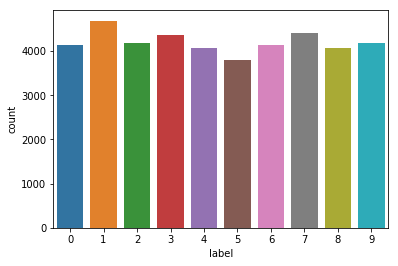

In [3]:
train = pd.read_csv("{}train.csv".format(path_to_data))
test = pd.read_csv("{}test.csv".format(path_to_data))
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
del train 
g = sns.countplot(Y_train)
Y_train.value_counts()

In [4]:
X_train.isnull().any().describe()
test.isnull().any().describe()
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [5]:
X_train=X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)


In [6]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [7]:
Y_train.shape

(42000, 10)

In [8]:
# Set the random seed
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)


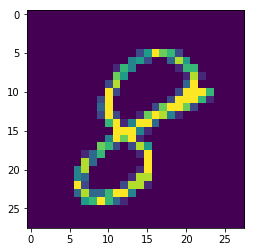

In [9]:
g = plt.imshow(X_train[0][:,:,0])

In [10]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [11]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [12]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [13]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86



In [14]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
